In [11]:
#Read in all of the relevant libraries
import numpy as np
import pandas as pd  #Pandas is a nice package for data reading/selection
import math
import scipy as sp
import matplotlib.pyplot as plt
import ellipses as el

from IPython.display import display
import sys
import pickle
import seaborn
seaborn.set_style('ticks')
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

This notebook is for postprocessing the large numbers of simulations we run with the metapopulations code. It takes a list of file names, reads in those simulations, then can calculate various quantities from those simulations to generate output figures. 

In [12]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [13]:
#Take a list of files to generate an output for that list. Will be nxm long, where n and m are the number of sims
#for each of the parameters you've looped over (need to tell it n and m)You'll need to set up the filenames so that 
#they actually go in the order you want. 
filenames = pd.read_csv('../Sims/test2/filelist.txt',delim_whitespace=True,header=None)
n = 5  #points along first parameter
m = 5  #points along second parameter

In [14]:
#Getting the file names in a workable format
filemat = filenames.values
filemat = filemat.flatten()
npoint = len(filemat)/4
filemat = filemat.reshape([4,npoint])


In [15]:
#'toplot' is the variable that you'll be calculating in order to generate a color map. 
#toplot = 'Ipercent' #Percentage of pop. (TOTAL) infected over course of simulation
toplot = 'ellipse'  #Number of patches that have 'high' infection - defined as greater than 5% of the pop.
#set up a matrix to hold the values of this variable:
plotmat = np.zeros([n,m])

In [16]:
#Select the subset of files you're going to work with (mostly for testing purposes):
files_subset = []
for i in range(n):
    files_subset.append(filemat[:,n*m*i:n*m*(i+1)])

#files_subset now contains nxm (x4, since there are I,S,R,and V files for each sim) 
#files for each of 10 different vaccination variance levels. If you want to make a grid looping over vacc. variance,
#you'll have to change the code quite a bit.

In [19]:
#Select all files with the same vacc. variance.
files = files_subset[0]
print np.shape(files)
print files[0,0]
burnin = 300

(4, 25)
cases_vaxvar0.05_popvar0.1_pop100000.0_0.csv


In [22]:
#This loop reads through all of the files and calculates the output variable, storing it in the plotmat matrix.
for i in range(n):
    print i
    for j in range(m):
        #Read in data file
        filenum = i*n+j%m
        print files[0,filenum]
        Ifile = pd.read_csv('../Sims/test2/'+files[0,filenum], delim_whitespace=True,header=0)
        Sfile = pd.read_csv('../Sims/test2/'+files[1,filenum], delim_whitespace=True,header=0)
        Rfile = pd.read_csv('../Sims/test2/'+files[2,filenum], delim_whitespace=True, header=0)
        Vfile = pd.read_csv('../Sims/test2/'+files[3,filenum], delim_whitespace=True,header=0)
        
        Idata_all = Ifile.values
        Sdata_all = Sfile.values
        Rdata_all = Rfile.values
        Vdata_all = Vfile.values
                
        Idata_all = Idata_all.astype(float)
        Sdata_all = Sdata_all.astype(float)
        Rdata_all = Rdata_all.astype(float)
        Vdata_all = Vdata_all.astype(float)
        
        tsteps = len(Idata_all[:,0])
        npatch = len(Idata_all[0,:])
        
        Idata = Idata_all[burnin:,:]
        Sdata = Sdata_all[burnin:,:]
        Rdata = Rdata_all[burnin:,:]
        Vdata = Vdata_all[burnin:,:]
        
        '''print j
        if (j-5)%10==0:
            print files[0,filenum]
            plt.plot(Idata)
            '''
        
        #Outbreaks are identified as any string of more than one time-step during which I>0 in a cell.
        if toplot=='Ipercent':
            outsize = np.zeros(npatch)
            k = 1
            while k<(tsteps-burnin):
                for r in range(npatch):
                    if Idata[k,r] > 0.:
                        if Idata[k-1,r] > 0.:
                            outsize[r] += Idata[k,r]
                k += 1

            totinf = sum(outsize)
            totpop = Idata+Sdata+Rdata+Vdata
            totpop = sum(totpop)
            fracinf = outsize/totpop
            print np.shape(outsize)

            plotmat[i,j] = max(fracinf)

        if toplot=='nhigh':
            nhigh = 0
            k = 0
            while k<(tsteps-burnin):
                Ifrac = Idata[k,:]/(Idata[k,:]+Sdata[k,:]+Rdata[k,:]+Vdata[k,:])
                mask = Ifrac>=0.05
                Ihigh = Ifrac[mask]
                #if len(Ihigh) < 400:
                 #   print Ifrac
                x = Ihigh*1.
                #nhigh += sum(x)
                nhigh += len(x)
                k+=1
            plotmat[i,j] = nhigh
            
        if toplot=='ellipse':
            nobs = len(Idata)      #How many 'observations'? (i.e. timesteps)
            dates = np.linspace(0,nobs-1,nobs) 
            dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
            theta = 2.*np.pi*((dates+1)/24.)
            
            eccen = []
            for k in range(400):
                thetafit = theta[:]
                Ifit = Idata[:,k]
                Ifit += 1.
                cartcoords = pol2cart(Ifit,thetafit)
                data = cartcoords

                lsqe = el.LSqEllipse()
                lsqe.fit(data)
                center, width, height, phi = lsqe.parameters()
                if height>width:
                    eccen.append(np.sqrt(1.-(height/width)**2.)
                if width>=height:
                    eccen.append(np.sqrt(1.-(width/height)**2.)
            plotmat[i,j] = np.mean(eccen)
    

SyntaxError: invalid syntax (<ipython-input-22-5b253b548b90>, line 90)

In [9]:
#Fix the ordering of columns.  i corresponds to popvar, j to popsize. This works for a 10x10 plot
#This is a gross kludge and should be fixed in the above loop instead.
holdcol0 = plotmat[:,0].copy()
holdcol1 = plotmat[:,5].copy()
matrix = plotmat.copy()
matrix[:,0] = holdcol1               #the fifth column should be the first column
matrix[:,5:9] = plotmat[:,6:].copy() #shift the last few columns left
matrix[:,-1] = holdcol0              #last column replaced with first

holdrow0 = matrix[0,:].copy()
holdrow1 = matrix[1,:].copy()
matrix[0,:] = holdrow1
matrix[1,:] = holdrow0

holdcol0 = plotmat[:,0].copy()
matrix = plotmat.copy()
matrix[:,0:-1] = plotmat[:,1:].copy()
matrix[:,-1] = holdcol0

#matrix[0,:] = holdrow1
#matrix[1,:] = holdrow0

/Users/laurasampson/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


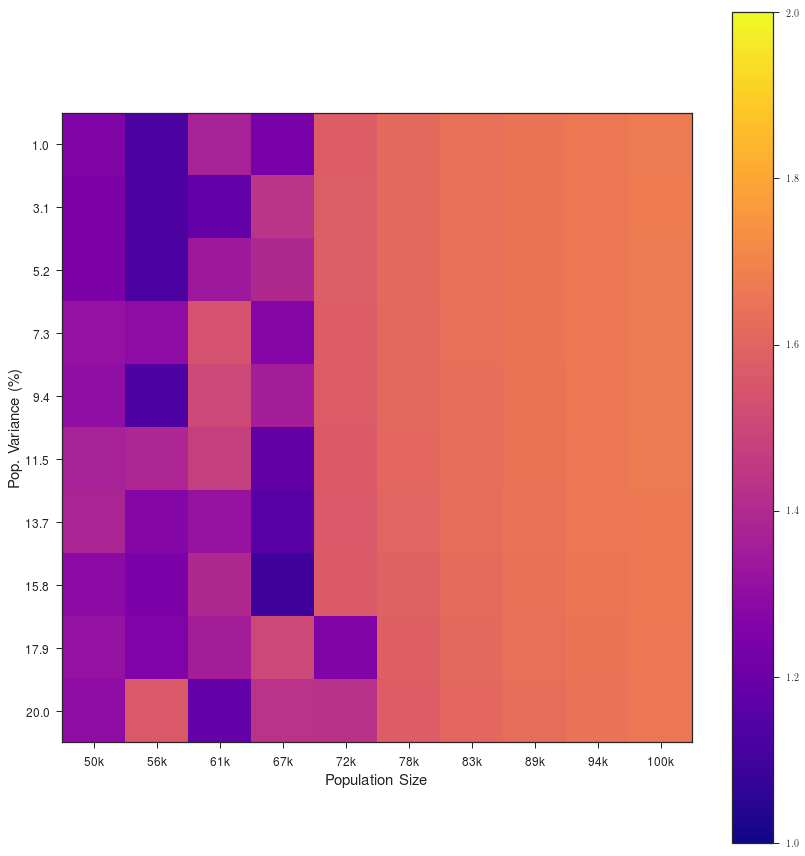

In [10]:
#print out a heatmap of the output variable.
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.imshow((matrix), interpolation='nearest', cmap='plasma',vmin=1.,vmax=2.)
ax.set_xticks(np.arange(0,10,1))
ax.set_yticks(np.arange(0,10,1))
ax.set_xticklabels(['50k','56k','61k','67k','72k','78k','83k','89k','94k','100k'],fontsize=12)
ax.set_yticklabels([1.0,3.1,5.2,7.3,9.4,11.5,13.7,15.8,17.9,20.],fontsize=12)
ax.set_xlabel('Population Size',fontsize=15)
ax.set_ylabel('Pop. Variance (\%)',fontsize=15)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
fig.tight_layout()

#plt.savefig('../Sims/alpha10c0.1/test.pdf')